使用opencv 3 处理图像

一 不同色彩空间的转换  
OpenCV中有数百种关于在不同色彩空间之间转换的方法。当前，在计算机中有三种常用的色彩空间：灰度，BGR以及HSV(Hue,Saturation,Value)。  
--灰度色彩空间是通过去除色彩信息来将其转换成灰阶，灰度色彩空间对中间处理特别有效，比如人脸检测。  
--BGR，即蓝-绿-红色彩空间，每一个像素点都由一个三元数组来表示，分别代表蓝、绿、红三种颜色。网页开发者可能熟悉另一个与之相似的色彩空间：RGB，他们只是在颜色顺序上不同。   
--HSV,H(Hue)是色调，S(Saturation)是饱和度，V(Value)表示黑暗的程度(或光谱另一端的命令程度)。  
在第一次处理BGR色彩空间的时候，可以不要其中的一个色彩分量，比如像素值[0 255 255]\(没有蓝色，绿色分量取最大值，红色分量取最大值)表示黄色。如果读者有艺术背景，会发现绿色和红色混合产生浑浊的褐色，这是因为计算所使用的颜色模型具有可加性并且处理的是光照，而绘画不是这样的(它遵从减色模型 subtractive color model)。计算机使用显示器发光来做颜色的媒介，因此运行在计算机上的软件所使用的色彩模型是加色模型。



二 傅里叶变换  
通过傅里叶变换来介绍图像的幅度谱(magnitude specturm)。图像的幅度谱是另一种图像，幅度谱图像呈现了原始图像在变化方面的一种表示：把一张图像中最明亮的像素放到图像中央，然后逐渐变暗，在边缘上像素最暗。这样可以发现图像中有多少亮的像素和暗的像素，以及它们分布的比例。  
傅里叶变换的概念是许多常见的图像处理操作的基础，比如边缘检测或线段和形状检测。  
1.高通滤波器  
高通滤波器(HPF)是检测图像的某个区域，然后根据像素与周围像素的亮度差值来提升该像素的亮度的滤波器。



In [3]:
# 以如下的核(kernel)，即滤波器矩阵为例：
import numpy
kernel = [[0, -0.25,0],
          [-0.25,1,-0.25],
          [0,-0.25,0]]
print(numpy.array(kernel))

[[ 0.   -0.25  0.  ]
 [-0.25  1.   -0.25]
 [ 0.   -0.25  0.  ]]


注：核是指一组权重的集合，它会应用在源图像的一个区域，并由此生成目标图像的一个像素。比如，大小为7的核意味着每49(7x7)个源图像的像素会产生目标图像的一个像素。可把核看做一块覆盖在源图像上可移动的毛玻璃片，玻璃片覆盖区域的光线会按某种方式进行扩散混合后透过去。  
   在计算完中央像素与周围邻近像素的亮度差值之和以后，如果亮度变化很大，中央像素的亮度会增加，反之则不会。换句话说，如果一个像素比它周围的像素更突出，就会提升它的亮度。  
   这在边缘检测上尤为有效，它采用一种称为高频提升滤波器(high boost filter)的高通滤波器。  
   高通和低通滤波器都有一个半径(radius)的属性，它决定了多大面积的临近像素参与滤波运算。

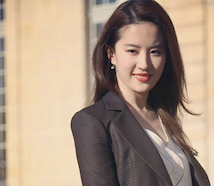

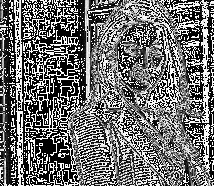

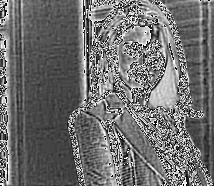

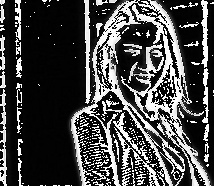

In [18]:
#下面是一个高通滤波器的例子，代码如下：
import cv2
import numpy as np
from scipy import ndimage

#高通滤波器
#这些滤波器中的所有值加起来为0
kernel_3x3 = np.array([[-1,-1,-1],
                       [-1,8,-1],
                       [-1,-1,-1]]) 
kernel_5x5 = np.array([[-1,-1,-1,-1,-1],
                       [-1,-1, 2, 1,-1],
                       [-1, 2, 4, 2,-2],
                       [-1, 1, 2, 2,-1],
                       [-1,-1,-1,-1,-1]])
#读取图像，指定格式为灰度图像 
img = cv2.imread('imori.jpg',cv2.IMREAD_GRAYSCALE)
#进行卷积运算
k3 = ndimage.convolve(img,kernel_3x3)
k5 = ndimage.convolve(img,kernel_5x5)
#高斯滤波，（11，11）表示高斯矩阵长宽都是11，标准差取0
blurred = cv2.GaussianBlur(img,(11,11),0)
#作差
g_hpf = img - blurred
#保存图片
cv2.imwrite('k3.jpg',k3)
cv2.imwrite('k5.jpg',k5)
cv2.imwrite('blurred.jpg',blurred)
cv2.imwrite('g_hpf.jpg',g_hpf)
#显示
from IPython.display import Image as IMG
display(IMG('imori.jpg'),IMG('k3.jpg'),IMG('k5.jpg'),IMG('g_hpf.jpg'))

导入 模块后，我们定义了一个3x3和一个5x5的核，然后将读入的图像转换成灰度格式。通常大多数图像处理都会用Numpy模块来完成，但是这里的情况比较特殊，因为需要用一个给定核与图像进行'卷积'，但是Numpy碰巧只接受一维数组。  
上面代码用了两个自定义卷积核来实现两个高通滤波器。最后又用一种不同的方法来实现高通滤波器：通过对图像应用低通滤波器之后，与原始图像计算差值。这样得到的效果会更好。  
 这里注意有一点需要注意：使用卷积进行运算，并不能保证的每个像素值都在0~255之间。对于在区间外的像素点会导致灰度图无法显示，所以还需要做归一化，然后每个值乘以255，再将所有的值映射到这个区间内。归一化算法:x=(x-Min)(Max-Min)，这样x的范围就在[0,1]之间了。我们在上面调用的函数ndimage.convolve()在内部已经做了这些处理，所以我们就不需要自己写归一化的处理过程了。
  
2 低通滤波器  
高通滤波器是根据像素与邻近像素的亮度差值来提升该像素的亮度。低通滤波器(LPF)则是在像素与周围像素的亮度差值小于一定特征值，平滑该像素的亮度。它主要用于去噪和模糊化，比如说，高斯模糊是最常用的模糊滤波器(平滑滤波器)之一，它是削弱高频信号强度的低通滤波器。




三 创建模块  
和CptureManager类和WindowManager类一样，滤波器需要在Cameo外也能被重用。所以需要把滤波器分割到各自的python模块或者python文件中。  
在Cameo.py的同一目录下创建一个filters.py文件，在该文件下添加一些滤波函数和类，fliters.py文件中需要导入如下模块：



In [20]:
import cv2
import numpy as np
import utils

在同一目录下还要创建一个名为utils.py的文件，该文件存放一些通用的数学函数，同时需要导入以下模块：

In [21]:
import cv2
import numpy as np 
import scipy.interpolate

四 边缘检测  
边缘在人类视觉和计算机视觉中均起着重要的作用。人类能够仅凭一张背景剪影或一个草图就能识别出物体的类型和姿态。  
Open CV提供了许多边缘检测滤波函数，包括以下：  
Laplacian()        #作为边缘检测函数，他会产生明显的边缘线条，灰度图像更是如此。  
Sobel()  
Scharr()  
这些滤波函数都会将非边缘区域转换为黑色，边缘区域转换成白色或其他饱和的颜色。但是这些函数都容易将噪声错误的识别为边缘。缓解这个问题的方法就是在找到边缘之前对图像进行模糊处理，去除噪声。  
Open CV也提供了需要模糊滤波函数，包括以下：  
blur()  #简单的算术平均  
medianBlur()  #它对去除数字化的视频噪声特别有效，特别是去除彩色图像的噪声  
GaussianBlur()

In [ ]:
import cv2
import numpy as np
import utils
def  strokeEdges(src,blurKsize=7,edgeKsize=5):
    '''
    该函数实现性能更好的边缘检测
    
    这里使用medianBlur()作为模糊函数，使用Laplacian()作为边缘检测函数。在使用medianBlur()之后，
    需要将图像从BGR色彩空间转换为灰度色彩空间。在得到Laplacian()函数结果之后，需要将图像转换为
    黑色边缘和白色背景(之前是白色边缘黑色背景)。然后将其归一化，并乘以源图像以便能将边缘变黑。
    
    args:
        src：源图像数据 BGR色彩空间       
        blurKsize：模糊滤波卷积核的宽和高  小于3，不进行模糊处理
        edgeKsize：边缘检测卷积核的宽和高

　　return:
　　　　 dst：目标图像数据 灰度色彩空间
    '''
    if blurKsize >= 3:
        #先模糊处理
        blurredSrc = cv2.medianBlur(src,blurKsize)
        cv2.imshow('blurredSrc',blurredSrc)
        #BGR格式转化为灰度格式
        graySrc = cv2.cvtColor(blurredSrc,cv2.COLOR_BGR2GRAY)
    else:
        graySrc = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
        
    cv2.imshow('graySrc',graySrc)
    #边缘检测 对灰度图像检测效果更好
    cv2.Laplacian(graySrc,cv2.CV_8U,graySrc,ksize = edgeKsize)
    cv2.imshow('laplacian',graySrc)
    
    #颜色反向处理 并归一化
    normalizedInverseAlpha = (1.0/255)*(255 - graySrc)
    cv2.imshow('normalizedInverseAlpha',normalizedInverseAlpha)
    
    #通道分离 B,G,R 单通道图像
    channels = cv2.split(src)
    cv2.imshow('B',channels[0])
    
    #计算后的结果分别与每个通道相乘
    for channel in channels:
        #这里是点乘，即对应元素相乘
        channel[:] = channel * normalizedInverseAlpha
            
    cv2.imshow('B1',channels[0])
    
    #通道合并(只能合并多个单通道成为多通道)
    return  cv2.merge(channels)
    
img = cv2.imread('imori.jpg',cv2.IMREAD_COLOR)
dst = strokeEdges(img)
cv2.imshow('dst',dst)
cv2.waitKey()
cv2.destroyAllWindows()